In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Probability of sharing distribution

We use the US 2016 elections dataset in "*Balancing Information Exposure in Social Networks*" to study the distribution of sharing probabilities.

In [37]:
# load seeds
A = [l.strip() for l in open("side1_seeds.txt").readlines()]  # A = pro Hillary
B = [l.strip() for l in open("side2_seeds.txt").readlines()]  # B = pro Trump
len(A), len(B)

(85, 99)

In [38]:
# load probabilities
df = pd.read_csv("uselections_network_heterogeneous.txt", sep='\t', names=['User1', 'User2', 'pA', 'pB'])
df

,User1,User2,pA,pB
0,003a04f8c2054b7,birdonachair,0.000834,0.008674
1,003a04f8c2054b7,patriot18d,0.001160,0.003320
2,003a04f8c2054b7,pamela_moore13,0.000143,0.004143
3,003a04f8c2054b7,jbaker31826004,0.000604,0.015884
4,003a04f8c2054b7,glucklichschon,0.001960,0.019880
...,...,...,...,...
845147,healthyyoga07,rickrwells,0.000250,0.010810
845148,healthyyoga07,supercos7,0.004560,0.015920
845149,healthyyoga07,ladiesfortrump,0.001448,0.032888
845150,healthyyoga07,usa_with_trump,0.001067,0.016427


## Homophily

In [104]:
# membership
labeled = df[(df.User1.isin(A) | df.User1.isin(B)) & (df.User2.isin(A) | df.User2.isin(B))].copy()
labeled['Group1'] = labeled.User1.isin(A).replace({True: 'A', False: 'B'})
labeled['Group2'] = labeled.User2.isin(A).replace({True: 'A', False: 'B'})
labeled.head()

,User1,User2,pA,pB,Group1,Group2
3282,1boxingking1,georgemason101,0.003017,0.082857,B,B
6861,20donaldtrump16,azz_amis,0.006907,0.086667,B,B
6865,20donaldtrump16,tukinovf,0.002937,0.082857,B,B
6870,20donaldtrump16,ronyerby,0.004160,0.084000,B,B
11871,6f1abe900f56450,honey17011,0.065718,0.000518,A,A


In [105]:
# replacement counts
replacements = (labeled.groupby(['Group1', 'Group2']).User1
                       .count()
                       .unstack(fill_value=0)
                       .stack()
                       .rename('Counts')
                       .reset_index()
                       .set_index(['Group1', 'Group2']))
replacements

Counts
Group1 Group2        
A      A          323
       B            4
B      A            0
       B          263

In [106]:
# group1 counts
groups = (labeled.groupby('Group1').User1
                 .count()
                 .rename('Counts')
                 .reset_index()
                 .set_index('Group1'))
groups

,Counts
Group1,
A,327
B,263


In [117]:
qs = (replacements / groups).rename(columns={'Counts': 'Probability'})
qs

Probability
Group1 Group2             
A      A          0.987768
       B          0.012232
B      A          0.000000
       B          1.000000

The following is the the homophily matrix (coordinates are the $q_g$, $1-q_g$, and 1- $q_{g'}$, $q_{g'}$ probabilities):

In [118]:
qs.unstack().values

array([[0.98776758, 0.01223242],
       [0.        , 1.        ]])

## Heterogenous model

Articles $a$ and $b$ propagate independently of each other: $u_2$ shares article $a$ with probability $p_A$, given that $u_1$ shared it. Analogously, $u_2$ shares article $b$ it with probability $p_B$, given that $u_1$ shared it.

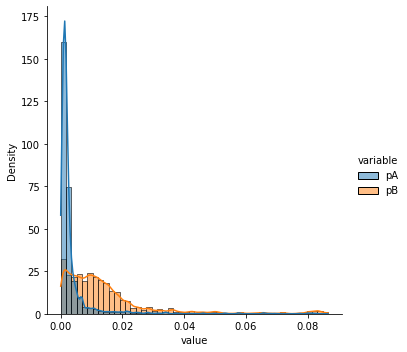

In [35]:
sns.displot(data=pd.melt(df,
                         id_vars=['User1', 'User2'],
                         value_vars=['pA', 'pB']),
            x='value',
            hue='variable',
            bins=50, kde=True, stat='density')

The pro-Trump distribution ($p_B$) is less skewed, meaning that pro-Trump tweets have higher probability of being retweeted.

Since the distribution should have support on $[0,1]$, a beta distribution may be a good choice to fit the data.

In [29]:
from scipy.stats import beta

# MLE estimates for the parameters of the beta distribution
a1, b1, loc1, scale1 = beta.fit(df.pA, floc=0, fscale=1)
a1, b1

(0.7961640748261505, 222.62377495491623)

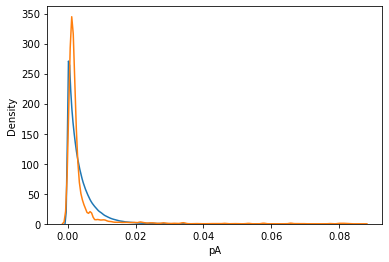

In [24]:
sns.kdeplot(np.random.beta(a=a1, b=b1, size=df.pA.shape[0]))
sns.kdeplot(df.pA)

In [30]:
# MLE estimates for the parameters of the beta distribution
a2, b2, loc2, scale2 = beta.fit(df.pB, floc=0, fscale=1)
a2, b2

(1.0402128477517107, 71.47304220053908)

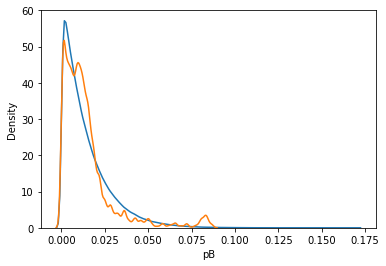

In [28]:
sns.kdeplot(np.random.beta(a=a2, b=b2, size=df.pB.shape[0]))
sns.kdeplot(df.pB)

The probabilities above are the conditional probabilities on a given initiator. We are implicitly assuming that the probability of sharing is independent of the initiator. This is probably not the case in practice since reputation and credibility are important factors for retweeting.

Let's calculate the average probability of sharing:

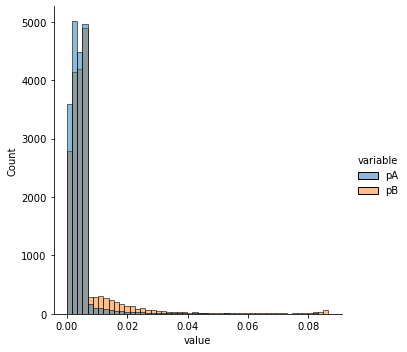

In [6]:
p_share = df.groupby('User2').mean().reset_index()
sns.displot(data=pd.melt(p_share,
                         id_vars=['User2'],
                         value_vars=['pA', 'pB']),
            x='value',
            hue='variable', bins=50)

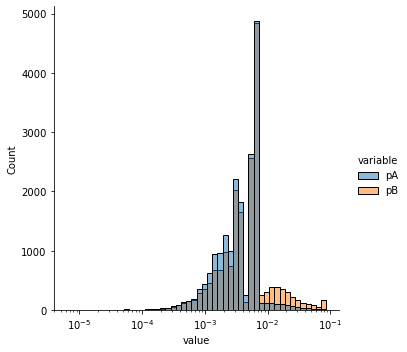

In [7]:
sns.displot(data=pd.melt(p_share,
                         id_vars=['User2'],
                         value_vars=['pA', 'pB']),
            x='value',
            hue='variable', bins=50, log_scale=(True, False))

## Different groups

Ideally, we would like to study the distributions of $p_{A, s}$ and $p_{B, s}$ and not just $p_{*, a}$ and $p_{*,b}$ (i.e., the probabilities of clicking on the articles regardless of group membership).

In [8]:
dfg = df[df.User2.isin(B) | df.User2.isin(A)]

In [9]:
group = df.User2.isin(A).replace({True: 'A', False: 'B'})

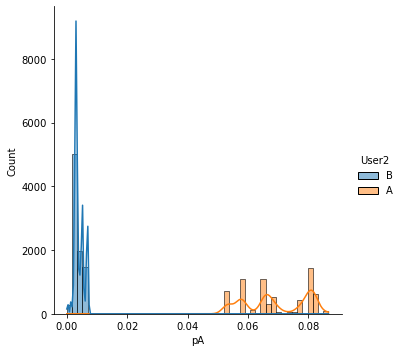

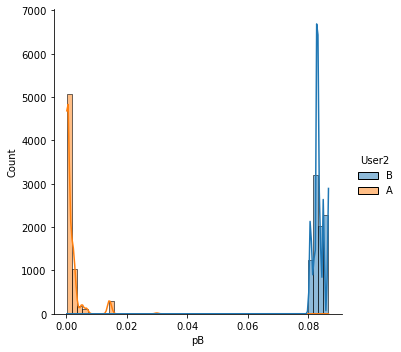

In [10]:
sns.displot(data=dfg, x='pA', hue=group, bins=50, kde=True)
sns.displot(data=dfg, x='pB', hue=group, bins=50, kde=True)

The symmetry makes sense because the probability of sharing the article that agrees with the group's views is higher than otherwise.